# Measure skew-spectra of DM in redshift space #

In [1]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style

import matplotlib.pyplot as plt
import numpy as np
import os

from lsstools.cosmo_model import CosmoModel
from lsstools.gen_cosmo_fcns import calc_f_log_growth_rate, generate_calc_Da
from lsstools.model_spec import get_trf_spec_from_list
from lsstools.paint_utils import mass_weighted_paint_cat_to_delta
from lsstools.results_db import retrieve_pickles
from lsstools.results_db.io import Pickler
from perr.path_utils import get_in_path
from lsstools.nbkit03_utils import get_csum, get_csqsum, apply_smoothing, catalog_persist, get_cstats_string, linear_rescale_fac, get_crms,convert_nbk_cat_to_np_array
from perr_private.model_target_pair import ModelTargetPair, Model, Target
from lsstools.sim_galaxy_catalog_creator import SimGalaxyCatalogCreator, PTChallengeGalaxiesFromRockstarHalos
from perr_private.read_utils import readout_mesh_at_cat_pos


#from nbodykit.lab import ArrayCatalog, BigFileMesh


plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [2]:
# path
sim_seed = 400
boxsize = 500.0
basedir = '/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000%d-01536-%.1f-wig/' % (sim_seed, boxsize)
sim_scale_factor = 0.625

Rsmooth = 10.
Ngrid = 256


# cosmology of ms_gadget sims (to compute D_lin(z))
# omega_m = 0.307494
# omega_bh2 = 0.022300
# omega_ch2 = 0.118800
# h = math.sqrt((omega_bh2 + omega_ch2) / omega_m) = 0.6774
cosmo_params = dict(Om_m=0.307494,
                   Om_L=1.0 - 0.307494,
                   Om_K=0.0,
                   Om_r=0.0,
                   h0=0.6774)

f_log_growth = np.sqrt(0.61826)



# Smoothings in lagrangian space, in Mpc/h
#Rsmooth_density_to_shift = 0.0   # 0.0 before 30/3/2020
#Rsmooth_displacement_source = 0.23   # 0.23 before 30/3/2020



LOS = np.array([1,0,0])

# Options for shifted field
#ShiftedFieldsNp = 1536
#ShiftedFieldsNmesh = 1536


# avg or sum. Should use avg to get correct velocity model.
#PsiDot_weighted_CIC_mode = 'avg'


# Below, 'D' stands for RSD displacement in Mpc/h: D=v/(aH)=f*PsiDot.
tex_names = {}

## Targets
# RSD displacement of DM subsample
DM_D0 = Target(
    name='DM_D0',
    in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr0.0015_ssseed40400.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity',
    val_component=0,
    rescale_factor='RSDFactor'
)

DM_subsample = Target(
    name='DM_subsample',
    in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr0.0015_ssseed40400.bigfile' % sim_scale_factor),
    position_column='Position'
)

DM_D0 = Target(
    name='DM_D0',
    in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr0.0015_ssseed40400.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity',
    val_component=0,
    rescale_factor='RSDFactor'
)


# PT Challenge galaxies from rockstar halos. Rockstar gives core positions and velocities.
# Units: 1/(aH) = 1./(a * H0*np.sqrt(Om_m/a**3+Om_L)) * (H0/100.) in Mpc/h / (km/s).
# For ms_gadget, get 1/(aH) = 0.01145196 Mpc/h/(km/s) = 0.0183231*0.6250 Mpc/h/(km/s).
# Note that MP-Gadget files have RSDFactor=1/(a^2H)=0.0183231 for a=0.6250 b/c they use a^2\dot x for Velocity.
assert sim_scale_factor == 0.625

# subbox of PT challenge galaxies, apply RSD to position (TEST)

assert sim_scale_factor == 0.625
gal_ptchall_with_RSD = Target(
    name='gal_ptchall_with_RSD',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % sim_scale_factor),
    position_column='Position',
    velocity_column='Velocity', 
    apply_RSD_to_position=True,
    RSD_los=LOS,
    RSDFactor=0.01145196,
    #val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    #val_component=0,
    #rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          #('Position', 'max', [100.,100.,20.])
         ]
    )

# subbox of PT challenge galaxies, y component
assert sim_scale_factor == 0.625
gal_ptchall_subbox_D1 = Target(
    name='gal_ptchall_D1',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=1,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          ('Position', 'max', [500.,500.,20.])
         ]
    )


In [3]:
### Models

z_rescalefac = linear_rescale_fac(current_scale_factor=1.0,
                                  desired_scale_factor=sim_scale_factor,
                                  cosmo_params=cosmo_params)

deltalin = Model(
    name='deltalin',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=z_rescalefac,
    read_mode='delta from 1+delta',
    filters=None,
    readout_window='cic')

def k0ovksq_filter_fcn(k, v, d=0):
    k2 = sum(ki**2 for ki in k)
    return np.where(k2 == 0.0, 0*v, 1j*k[d] * v / (k2))
deltalin_D0 = Model(
    name='deltalin_D0',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=f_log_growth*z_rescalefac,
    read_mode='delta from 1+delta',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')


## Get DM catalog in redshift space ##

In [4]:
velocity_source = 'deltalin_D0'
#velocity_source = 'DM_sim'



# get the catalog
#target = gal_ptchall_with_RSD
target = DM_subsample
#target = DM_D0

BoxSize = np.array([boxsize, boxsize, boxsize])

cat = target.get_catalog(keep_all_columns=True)
print(cat.attrs)


# add redshift space positions, assuming LOS is in x direction, and using DM velocity
LOS = np.array([1,0,0])
if velocity_source == 'DM_sim':
    cat['RSDPosition'] = cat['Position'] + cat['Velocity']*cat.attrs['RSDFactor'] * LOS
elif velocity_source == 'deltalin_D0':
    mtp = ModelTargetPair(model=deltalin_D0, target=DM_subsample)
    cat['RSDPosition'] = cat['Position'].compute()
    mat = np.zeros((cat.csize,3))
    mat[:,0] = mtp.readout_model_at_target_pos()
    mat[:,1] = 0*mat[:,0]
    mat[:,2] = 0*mat[:,0]
    cat['RSDPosition'] += mat

print(cat.columns)  
cat = catalog_persist(cat, columns=['ID','PID','Position','RSDPosition','Velocity',
                                    'log10Mvir'])
print(cat.columns)



Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250_sub_sr0.0015_ssseed40400.bigfile
Cuts removed 0% of objects
{'MassTable': array([0.      , 0.294384, 0.      , 0.      , 0.      , 0.      ]), 'UnitVelocity_in_cm_per_s': array([100000.]), 'CMBTemperature': array([2.7255]), 'BoxSize': array([500.]), 'HubbleParam': array([0.6774]), 'TimeIC': array([0.01]), 'TotNumPart': array([         0, 3623878656,          0,          0,          0,
                0], dtype=uint64), 'Time': array([0.625]), 'UnitMass_in_g': array([1.989e+43]), 'Omega0': array([0.307494]), 'CodeVersion': array([u'5', u'.', u'0', u'.', u'0', u'.', u'd', u'e', u'v', u'1', u'_',
       u'3', u'a', u'4', u'9', u'f', u'8', u'4', u'2', u'a', u'd', u'_',
       u'd', u'i', u'r', u't', u'y'], dtype='<U1'), 'RSDFactor': array([0.01832314]), 'CompilerSettings': array([u' ', u'm', u'p', u'i', u'c', u'c', u' ', u'\n', u' ', u' ', u'-',
       u'f', u'o', u'p', u'e', u'n', u'm', u'p', u' 

/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


MESH deltalin_D0: rms, min, mean, max: 3.38568 -16.6518 -4.86325e-08 16.703

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250_sub_sr0.0015_ssseed40400.bigfile
Cuts removed 0% of objects
['GroupID', 'ID', 'Mass', 'Position', 'Potential', 'RSDPosition', 'Selection', 'Value', 'Velocity', 'Weight']
['ID', 'Position', 'RSDPosition', 'Selection', 'Value', 'Velocity', 'Weight']


In [5]:
print('rms RSD displacement: %g Mpc/h' % np.mean((cat['Position'].compute()-cat['RSDPosition'].compute())**2)**0.5)
print('max RSD displacement: %g Mpc/h' % np.max(np.abs(cat['Position'].compute()-cat['RSDPosition'].compute())))

rms RSD displacement: 1.65832 Mpc/h
max RSD displacement: 15.9198 Mpc/h


In [6]:
cat.attrs

{'BoxSize': array([500.]),
 'CMBTemperature': array([2.7255]),
 'CodeVersion': array([u'5', u'.', u'0', u'.', u'0', u'.', u'd', u'e', u'v', u'1', u'_',
        u'3', u'a', u'4', u'9', u'f', u'8', u'4', u'2', u'a', u'd', u'_',
        u'd', u'i', u'r', u't', u'y'], dtype='<U1'),
 'CompilerSettings': array([u' ', u'm', u'p', u'i', u'c', u'c', u' ', u'\n', u' ', u' ', u'-',
        u'f', u'o', u'p', u'e', u'n', u'm', u'p', u' ', u'-', u'O', u'3',
        u' ', u'-', u'g', u' ', u'-', u'W', u'a', u'l', u'l', u' ', u'-',
        u'f', u'f', u'a', u's', u't', u'-', u'm', u'a', u't', u'h', u' ',
        u'-', u'm', u'a', u'r', u'c', u'h', u'=', u'n', u'a', u't', u'i',
        u'v', u'e', u' ', u'\n', u' ', u' ', u'-', u'D', u'D', u'E', u'N',
        u'S', u'I', u'T', u'Y', u'_', u'I', u'N', u'D', u'E', u'P', u'E',
        u'N', u'D', u'E', u'N', u'T', u'_', u'S', u'P', u'H', u' ', u'\n',
        u' ', u' ', u'-', u'D', u'O', u'P', u'E', u'N', u'M', u'P', u'_',
        u'U', u'S', u'E', u'_', 

## Calculate power spectrum multipoles ##

In [7]:
from nbodykit.lab import FFTPower, FieldMesh
def calc_power(mesh, second=None, mode='1d', k_bin_width=1.0, verbose=False, los=None, poles=None):
    BoxSize = mesh.attrs['BoxSize']
    assert BoxSize[0] == BoxSize[1]
    assert BoxSize[0] == BoxSize[2]
    boxsize = BoxSize[0]
    dk = 2.0 * np.pi / boxsize * k_bin_width
    kmin = 2.0 * np.pi / boxsize / 2.0

    if mode == '1d':
        res = FFTPower(first=mesh,
                        second=second,
                        mode=mode,
                        dk=dk,
                        kmin=kmin)
    elif mode == '2d':
        if poles is None:
            poles = [0,2,4]
        res = FFTPower(first=mesh,
                            second=second,
                            mode=mode,
                            dk=dk,
                            kmin=kmin,
                            poles=poles,
                            Nmu=5,
                            los=los)
    else:
        raise Exception("Mode not implemented: %s" % mode)

    return res

In [8]:
## Compute power spectrum 
Nmesh = Ngrid

# original catalog in redshift space
#RSDcat = catalog_persist(cat, columns=['RSDPosition', 'residual_D0'])
#RSDcat['Position'] = RSDcat['RSDPosition']
#del cat

print('# objects: Original: %d' % (cat.csize))

delta_mesh = FieldMesh(cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, 
                      window='cic', interlaced=False, compensated=False).compute()-1)
print('Mesh: ', get_cstats_string(delta_mesh.compute()))



Pdd = calc_power(delta_mesh, los=LOS, mode='2d', poles=[0,2,4,6])



# objects: Original: 5434925
Mesh:  rms, min, mean, max: 2.56686 -1 9.38599e-10 683.813


In [9]:
Pdd.attrs

{'BoxSize': array([500., 500., 500.]),
 'Lx': 500.0,
 'Ly': 500.0,
 'Lz': 500.0,
 'N1': 0,
 'N2': 0,
 'Nmesh': array([256, 256, 256]),
 'Nmu': 5,
 'dk': 0.012566370614359173,
 'kmin': 0.006283185307179587,
 'los': array([1, 0, 0]),
 'mode': '2d',
 'poles': [0, 2, 4, 6],
 'shotnoise': 0,
 'volume': 125000000.0}

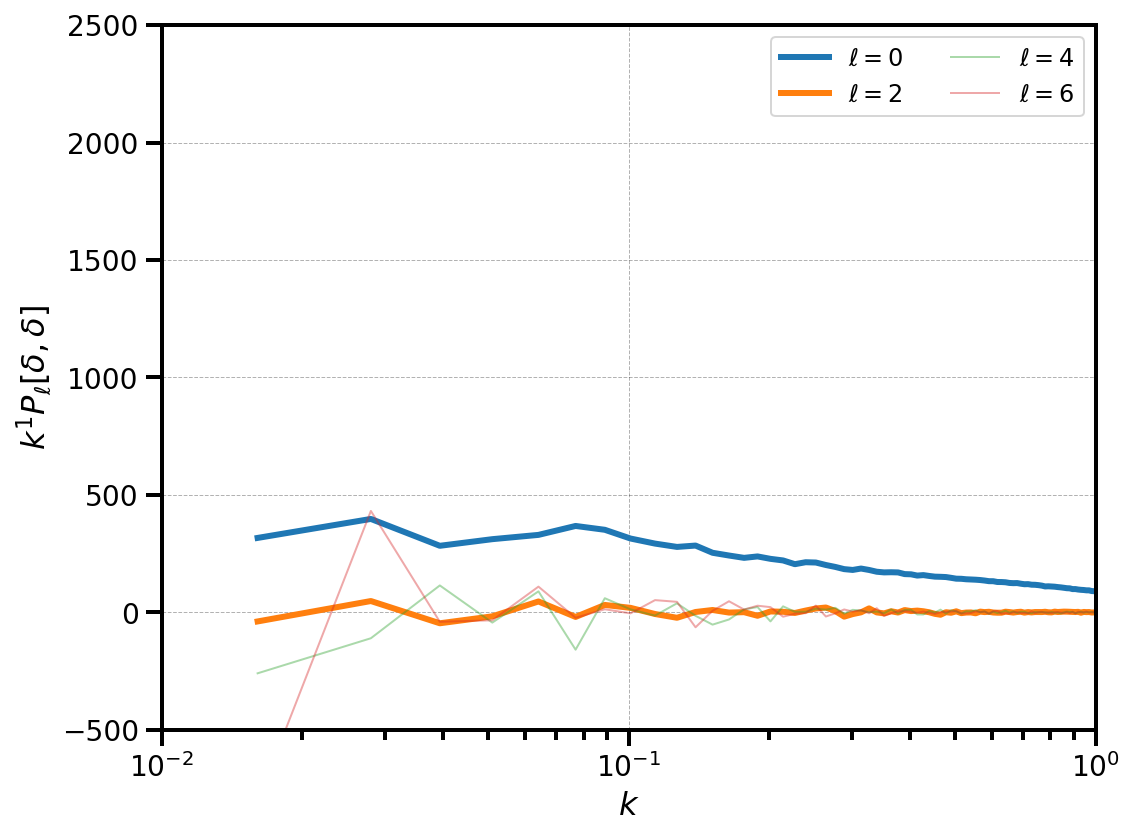

In [10]:
# plot power spectrum of density
plt.figure(figsize=(8,6))
kvec = Pdd.poles['k']
kpow = 1

for ell in Pdd.attrs['poles']:
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    plt.semilogx(kvec, (kvec**kpow*Pdd.poles['power_%d'%ell].real), label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylabel(r'$k^%dP_\ell[\delta,\delta]$' % kpow)
plt.tight_layout()
plt.ylim((-500,2500));


## Compute skew spectra ##

In [11]:
delta2 = FieldMesh((delta_mesh.compute())**2)
P_delta2_delta = calc_power(delta2, second=delta_mesh, los=LOS, mode='2d', poles=[0,2,4,6])

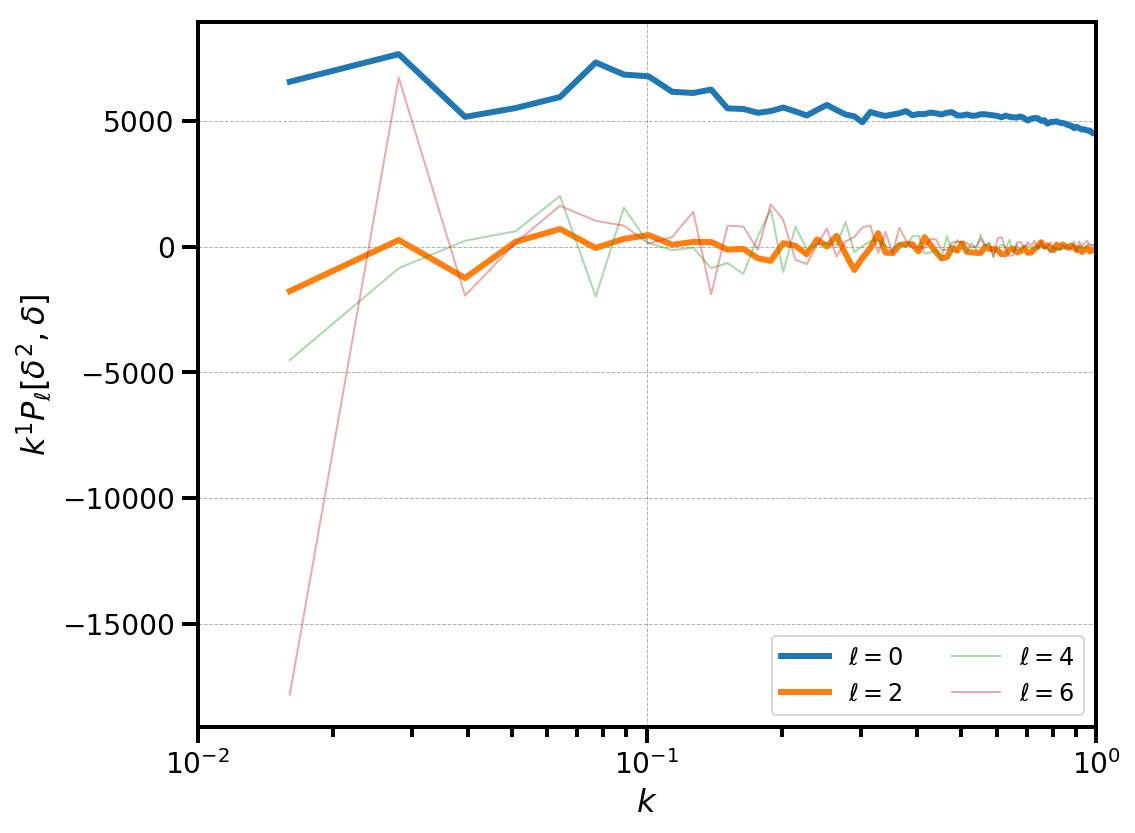

In [12]:
# plot power spectrum 
plt.figure(figsize=(8,6))
kvec = P_delta2_delta.poles['k']
kpow = 1

for ell in P_delta2_delta.attrs['poles']:
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    plt.semilogx(kvec, (kvec**kpow*P_delta2_delta.poles['power_%d'%ell].real), label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylabel(r'$k^%dP_\ell[\delta^2,\delta]$' % kpow)
plt.tight_layout()
#plt.ylim((-500,2500));



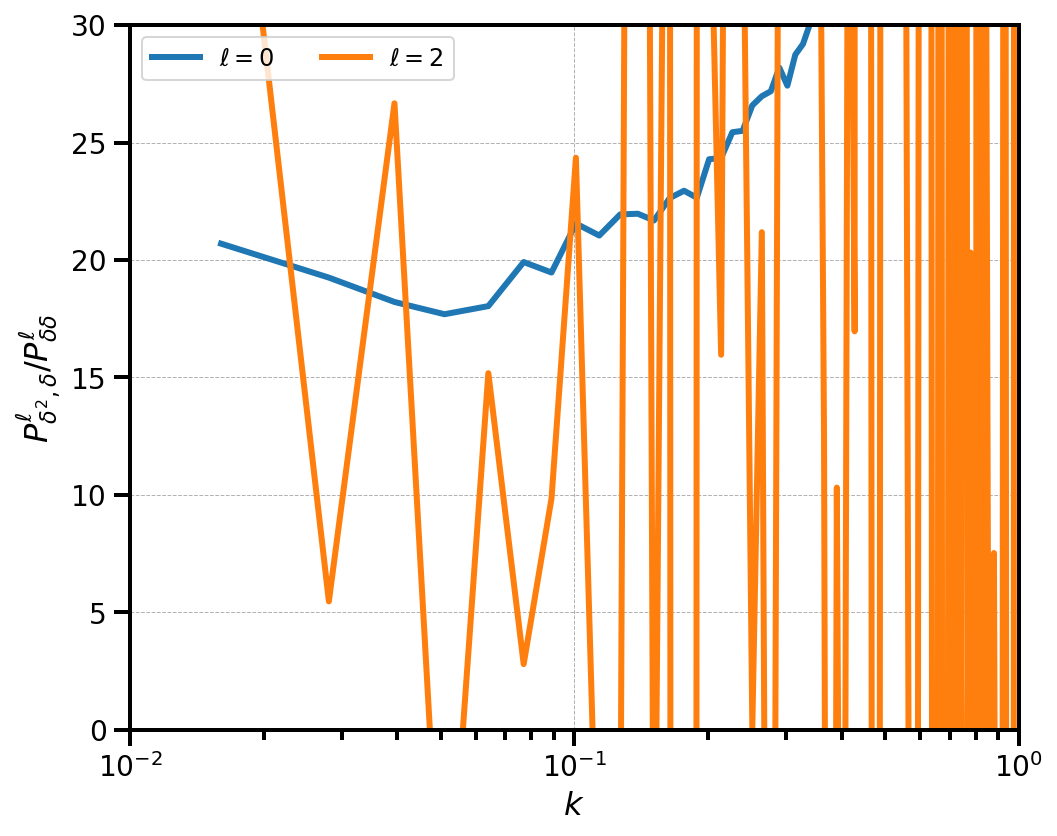

In [13]:
# plot P_{d2,d}/P_dd
plt.figure(figsize=(8,6))
kvec = P_delta2_delta.poles['k']
kpow = 1

for ell in [0,2]:
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    plt.semilogx(kvec, P_delta2_delta.poles['power_%d'%ell].real/Pdd.poles['power_%d'%ell].real,
                 label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylabel(r'$P^\ell_{\delta^2,\delta}/P^\ell_{\delta\delta}$')
plt.tight_layout()
plt.ylim((0,30));




In [14]:
from skewspec import smoothing
from skewspec.skew_spectrum import SkewSpectrum, compute_dnm, compute_dnm_dnmprime


In [15]:
# apply smoothing
from skewspec import smoothing
smoothers = [smoothing.GaussianSmoother(R=Rsmooth)]
delta_mesh_smoothed = FieldMesh(delta_mesh.compute(mode='real'))
for smoother in smoothers:
    delta_mesh_smoothed = smoother.apply_smoothing(delta_mesh_smoothed)
    
print('delta: ', get_cstats_string(delta_mesh.compute(mode='real')))
print('delta smoothed: ', get_cstats_string(delta_mesh_smoothed.compute(mode='real')))

delta:  rms, min, mean, max: 2.56686 -1 9.38599e-10 683.813
delta smoothed:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053


In [16]:
test_quad_field = compute_dnm_dnmprime(delta_mesh_smoothed, n=0, nprime=-2, m=[0,0,0], mprime=[1,0,0])

d_0^000:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d_-2^100:  rms, min, mean, max: 2.77019 -10.7844 3.46128e-10 12.0557
d_0^000:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d_-2^100 prime:  rms, min, mean, max: 2.77019 -10.7844 3.46128e-10 12.0557
d*dprime:  rms, min, mean, max: 0.816013 -11.1676 -0.0519242 14.5607


In [17]:
S2 = SkewSpectrum(name='S2', LOS=LOS)
S3 = SkewSpectrum(name='S3', nprime=-2, mprime=LOS, mprimeprime=LOS, LOS=LOS)
S5 = SkewSpectrum(name='S5', nprime=-2, mprime=2*LOS, LOS=LOS)
S6a = SkewSpectrum(name='S6a', nprime=-4, mprime=3*LOS,mprimeprime=LOS, LOS=LOS)
S6b = SkewSpectrum(name='S6b', prefactor=2.0, n=-2, nprime=-2, m=LOS, mprime=2*LOS, mprimeprime=LOS, LOS=LOS)
S8 = SkewSpectrum(name='S8', n=-2, nprime=-2, m=2*LOS, mprime=2*LOS, LOS=LOS)
S9a = SkewSpectrum(name='S9a', n=-4, nprime=-2, m=4*LOS, mprime=LOS, mprimeprime=LOS, LOS=LOS)
S9b = SkewSpectrum(name='S9b', prefactor=2.0, n=-4, nprime=-2, m=3*LOS, mprime=2*LOS, mprimeprime=LOS, LOS=LOS)
S11 = SkewSpectrum(name='S11', n=-4, nprime=-4, m=3*LOS, mprime=4*LOS, mprimeprime=LOS, LOS=LOS)

In [18]:
power_kwargs={'mode': '2d', 'poles':[0,2]}
skew_spectra = [S2,S3,S5,S6a,S6b, S8, S9a, S9b, S11]
for skew_spec in skew_spectra:
    # compute and store in skew_spec.Pskew
    skew_spec.compute_from_mesh(mesh=delta_mesh_smoothed, third_mesh=delta_mesh, power_kwargs=power_kwargs)

d_0^000:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d_0^000:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d_0^000:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d_0^000 prime:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d*dprime:  rms, min, mean, max: 0.157684 2.72005e-15 0.0785387 9.32082
d_0^000:  rms, min, mean, max: 2.56686 -1.00002 9.09495e-10 683.813
d_0^000:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d_-2^100:  rms, min, mean, max: 2.77019 -10.7844 3.46128e-10 12.0557
d_0^000:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d_-2^100 prime:  rms, min, mean, max: 2.77019 -10.7844 3.46128e-10 12.0557
d*dprime:  rms, min, mean, max: 0.816013 -11.1676 -0.0519242 14.5607
d_0^100:  rms, min, mean, max: 1.66541 -190.934 3.95062e-12 191.907
d_0^000:  rms, min, mean, max: 0.280248 -0.6932 -1.76806e-09 3.053
d_-2^200:  rms, min, mean, max: 0.125178 -0.387546 -9.7134e-10 1.02077
d_0^000:  rms, min, mean, max: 0.2

Made ../pdf/skew0_DM_R10.0_Ng256.pdf
Made ../pdf/skew1_DM_R10.0_Ng256.pdf


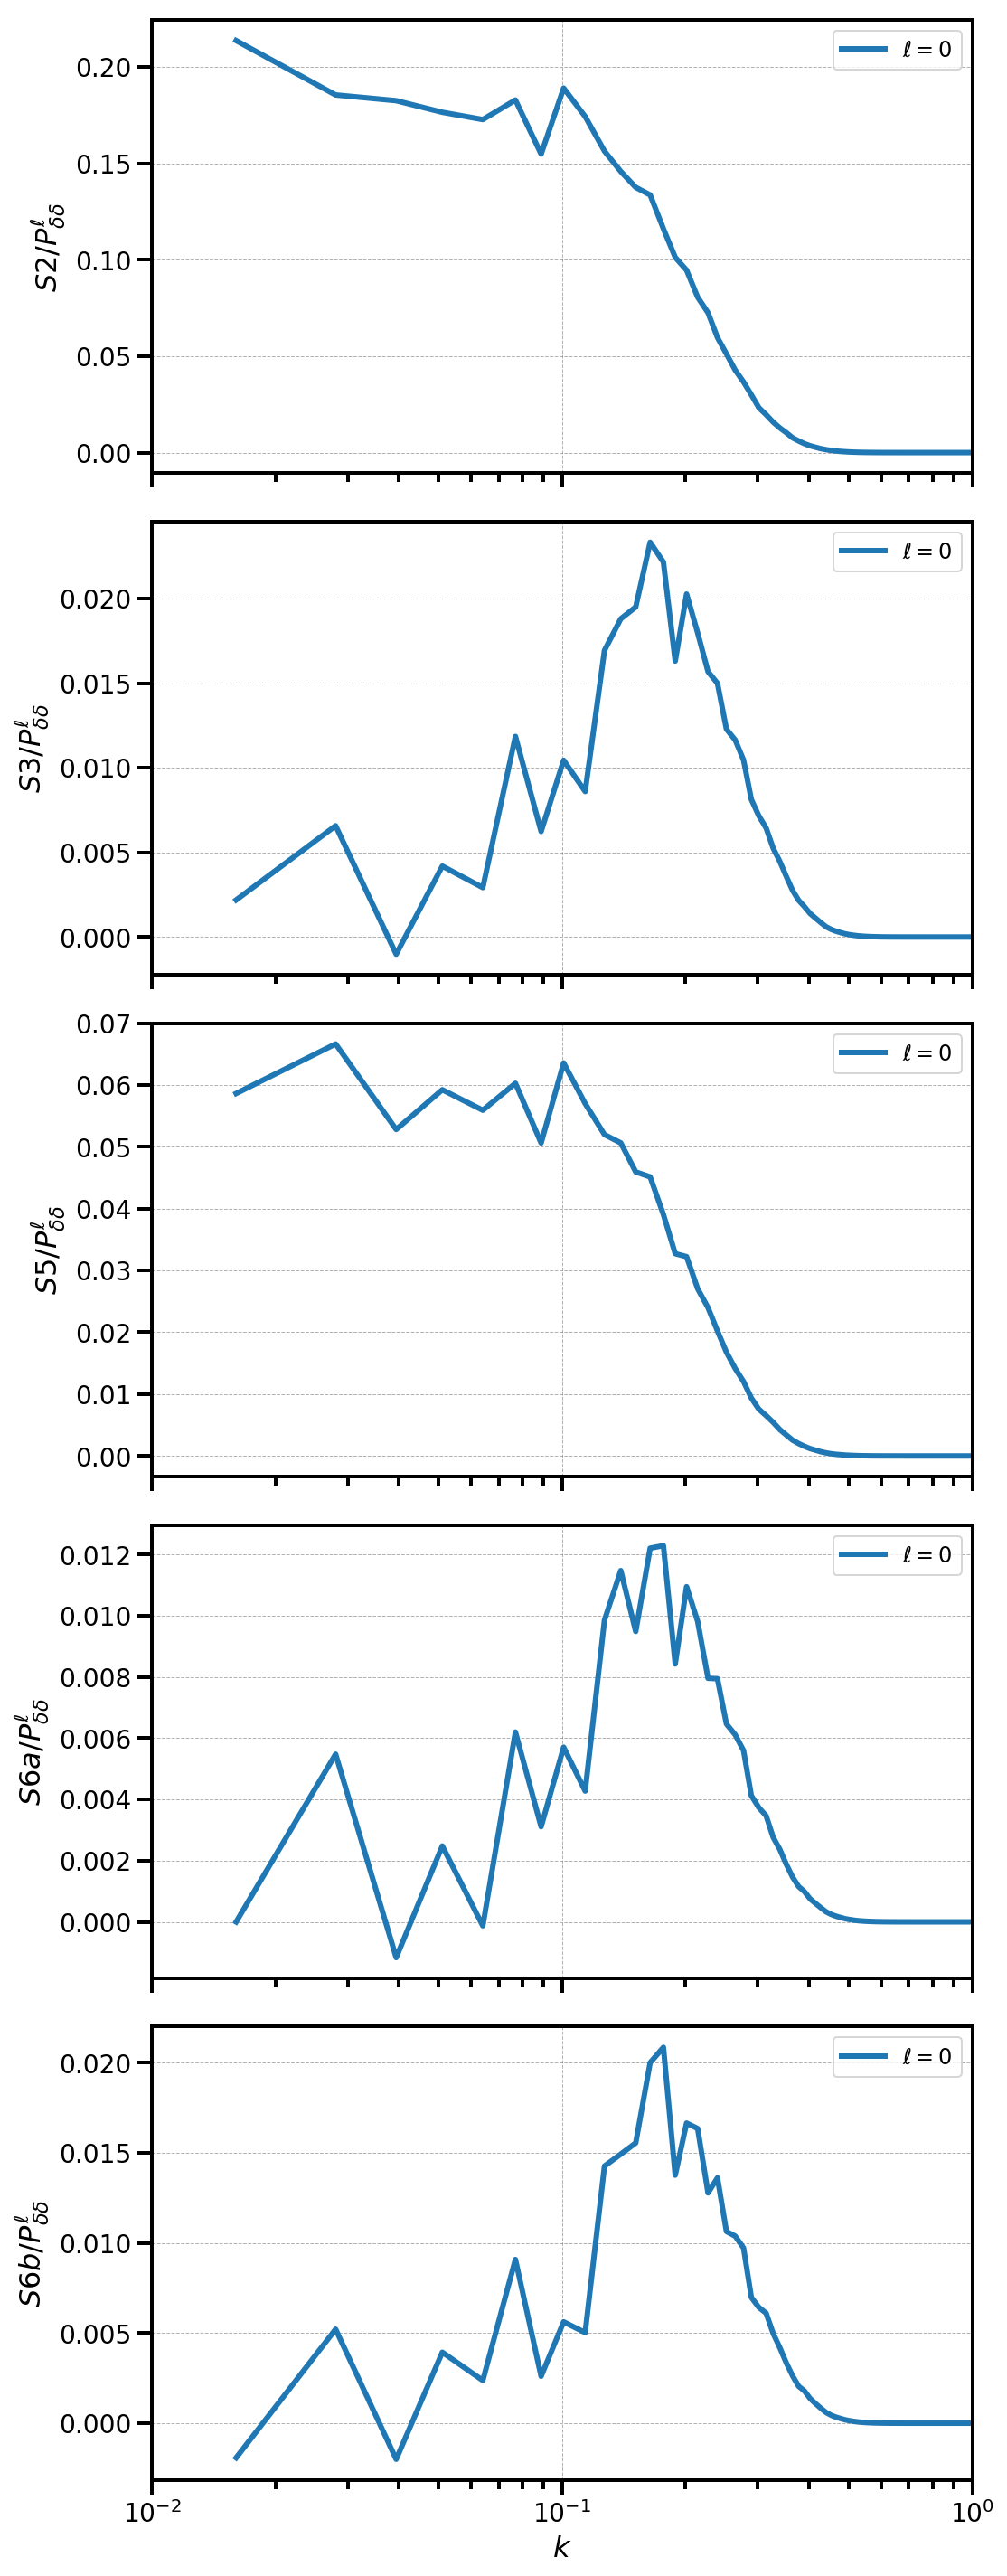

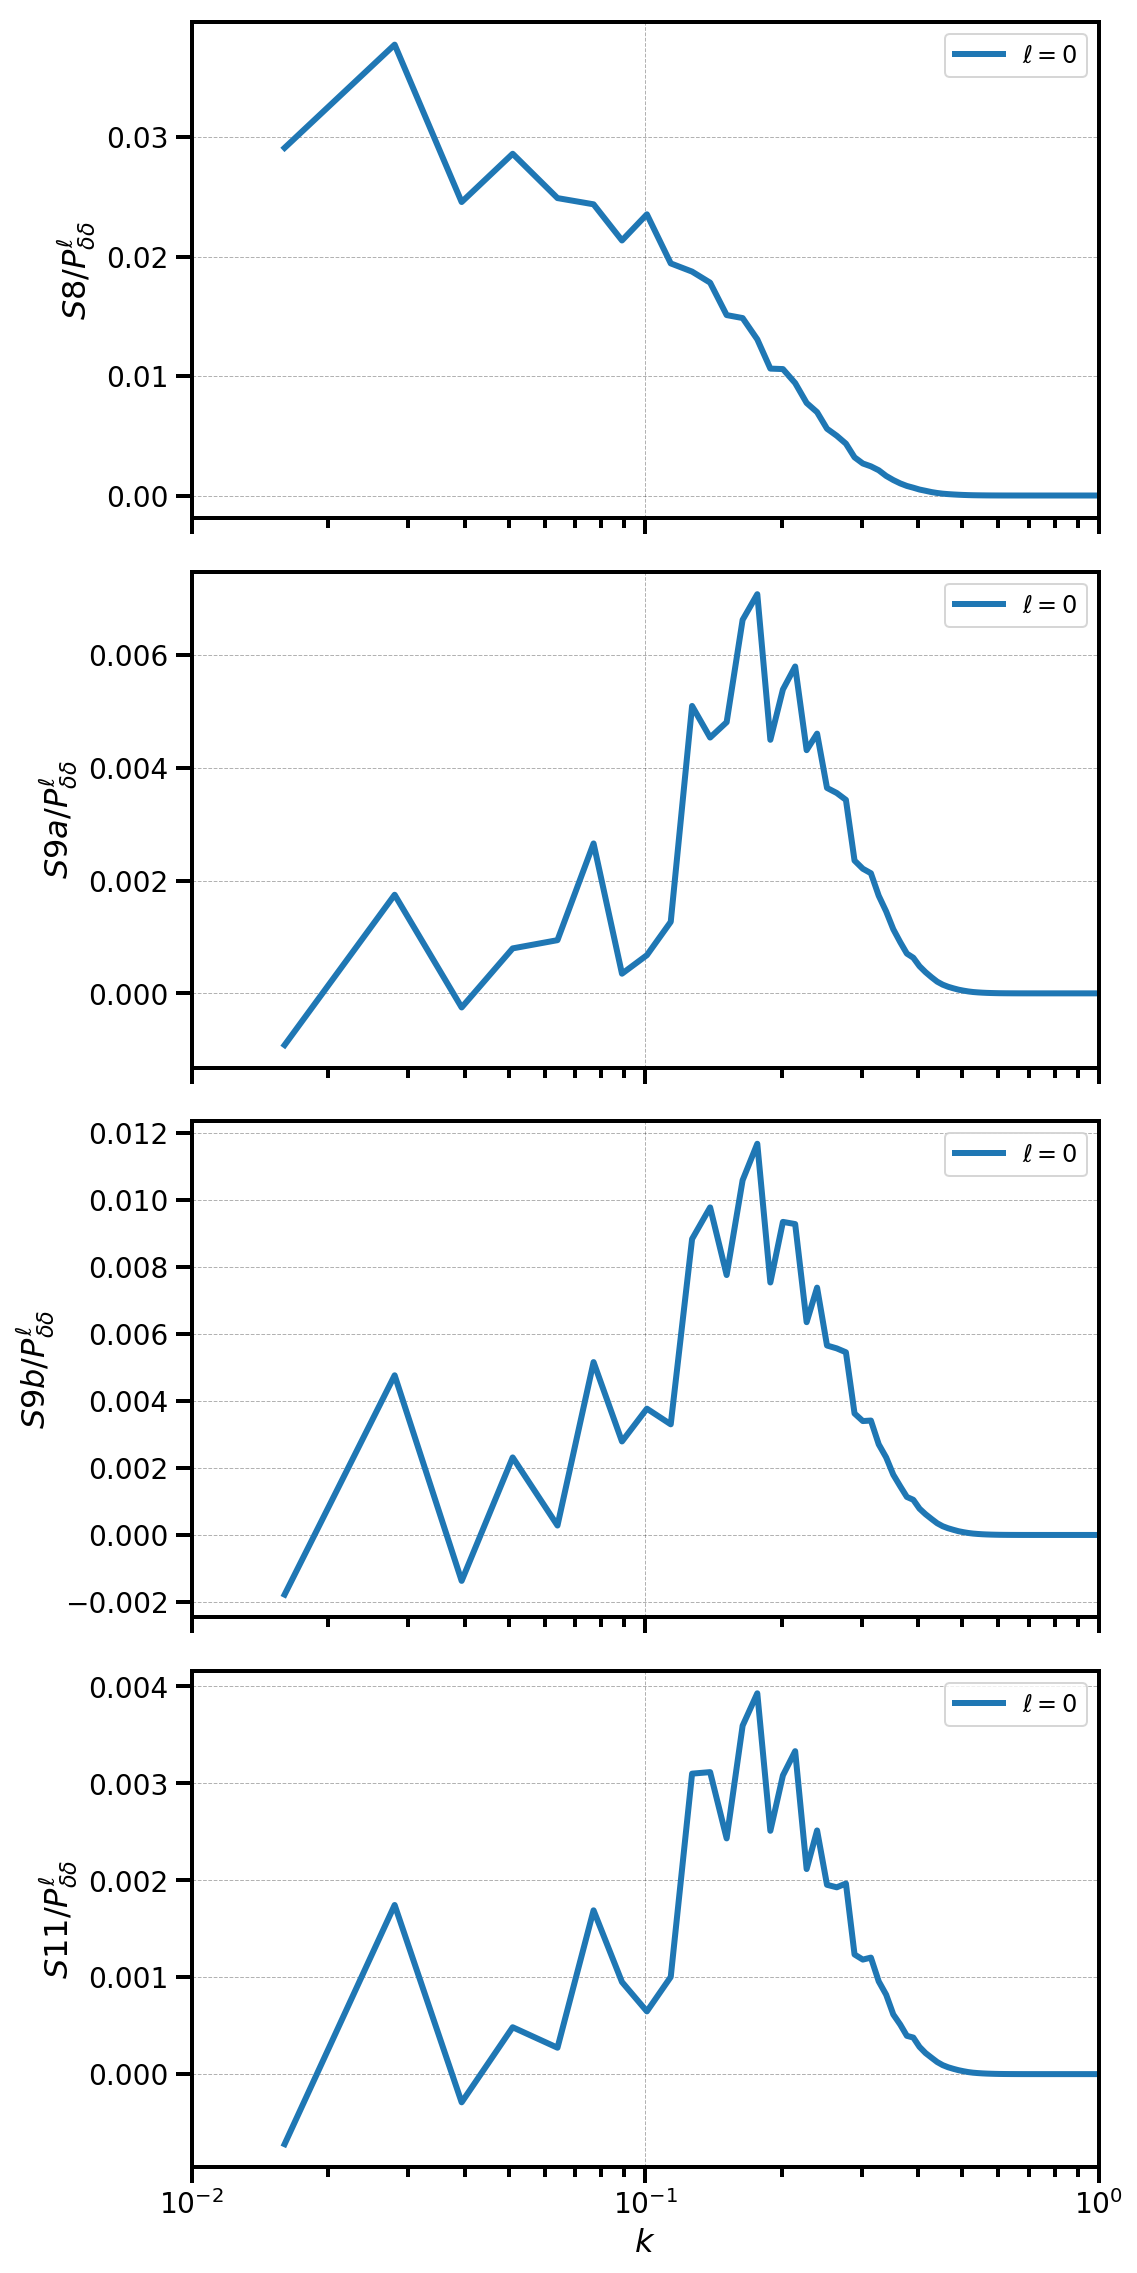

In [22]:
# plot Pskew/P_dd
for bunch in [0,1]:
    if bunch == 0:
        plt_spectra = skew_spectra[:5]
    elif bunch == 1:
        plt_spectra = skew_spectra[5:]
    

    fig, axarr = plt.subplots(len(plt_spectra), 1, figsize=(8,4*len(plt_spectra)),
                             sharex=True)

    kvec = Pdd.poles['k']

    for i,skew_spec in enumerate(plt_spectra):
        ax = axarr[i]

        for ell in [0]:
            if ell>2:
                lw, alpha = 1,0.4
            else:
                lw, alpha = 3,1
            ax.semilogx(kvec, skew_spec.Pskew.poles['power_%d'%ell].real/Pdd.poles['power_%d'%ell].real,
                         label=r'$\ell=%d$'%ell,
                    lw=lw, alpha=alpha)

        ax.set_xlim((0.01,1))
        ax.legend(loc='best', ncol=2, fontsize=12)
        ax.set_ylabel(r'$%s/P^\ell_{\delta\delta}$' % skew_spec.name)
    axarr[-1].set_xlabel(r'$k$') 

    #axarr[0].set_ylim((0,50))
    #axarr[1].set_ylim((-2,2))

    plt.tight_layout()

    fname = '../pdf/skew%d_DM_R%.1f_Ng%d.pdf' % (bunch,Rsmooth,Nmesh)
    plt.savefig(fname)
    print('Made %s' % fname)